## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, all used libraries are imported

In [ ]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gs
% matplotlib inline

## Helper Functions

In [2]:
def undistort(img, objpoints, imgpoints):
    # Get the size of the image
    img_size = (img.shape[1], img.shape[0])
    # Get distortion coefficients (dist) and camera matrix (mtx)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    # Calibrate Camera
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    return undistorted


def perspective_transform(img):
  # four original source points to transform.
    calib_img_x = img.shape[1]
    calib_img_y = img.shape[0]
    margin = 0.05

    src_top_right = [750, 450]
    src_bot_right = [1200, 680]
    src_bot_left = [100, 680]
    src_top_left = [550, 450]

    src = np.float32([src_top_right,
                      src_bot_right,
                      src_bot_left,
                      src_top_left])

    # four destination points
    dst_top_right = [int(calib_img_x*(1-margin)), 0]
    dst_bot_right = [int(calib_img_x*(1-margin))-125, calib_img_y]
    dst_bot_left = [int(calib_img_x*margin)+125, calib_img_y]
    dst_top_left = [int(calib_img_x*margin), 0]
    dst = np.float32([dst_top_right,
            dst_bot_right,
            dst_bot_left,
            dst_top_left])

    ## Compute and apply perspective transform
    img_size = (calib_img_x, calib_img_y)
    # Get Transform Matrix and its Inverse
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Return Warped Image
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image
    return Minv, warped

def mask(img):
    #Thresholds
    yellow_lower_filter = np.array([0, 100, 100])
    yellow_upper_filter = np.array([80, 255, 255])

    white_lower_filter = np.array([200, 200, 200])
    white_upper_filter = np.array([255, 255, 255])

    #yellow masking
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    yellow_mask = cv2.inRange(hsv, yellow_lower_filter, yellow_upper_filter)
    yellow_mask = cv2.bitwise_and(img, img, mask=yellow_mask)

    #white masking
    rgb = img
    white_mask = cv2.inRange(rgb, white_lower_filter, white_upper_filter)
    white_mask = cv2.bitwise_and(img, img, mask=white_mask)

    #combined masks
    combined_mask = cv2.bitwise_or(white_mask, yellow_mask)

    #convert to binary image
    gray_mask = cv2.cvtColor(combined_mask, cv2.COLOR_RGB2GRAY)
    binary = np.zeros_like(gray_mask)
    binary[(gray_mask > 0)] = 1
    return yellow_mask, white_mask, binary

def final_mask(img):
    # Color masking
    y, w, color_mask = mask(img)
    # Sobel Masking
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

    h = hls[:, :, 0]
    l = hls[:, :, 1]
    s = hls[:, :, 2]

    sobelx_light_mask = abs_sobel_thresh(l, orient='x', thresh=(50, 225))
    sobelx_saturation_mask = abs_sobel_thresh(s, orient='x', thresh=(50, 225))
    combined_sobel = cv2.bitwise_or(sobelx_light_mask, sobelx_saturation_mask)

    # Final Mask
    final_mask = cv2.bitwise_or(combined_sobel, color_mask)
    binary_warped = np.copy(final_mask)

    return binary_warped

def gaussian_blur(img, kernel=5):
    # Apply Gaussian Blur
    blur = cv2.GaussianBlur(img,(kernel,kernel),0)
    return blur

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Applying gradient
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    # Create copy and apply threshold
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary


def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx ** 2 + sobely ** 2)
    scale_factor = np.max(gradmag) / 255
    gradmag = (gradmag / scale_factor).astype(np.uint8)
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return mag_binary


def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi / 2)):
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    # apply a threshold, and create a binary image result
    dir_binary = np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return dir_binary

## Begin by calibrating the camera

In [3]:
# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6 * 9, 3), np.float32)
objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

# Arrays to store object points and image points from all the images.
objpoints = []  # 3d points in real world space
imgpoints = []  # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9, 6), corners, ret)

## After finding the object points and image points, the original chessboard image is plotted against its undistorted counter part to ensure the camera was correctly calibrated

In [4]:
def plot_distort_vs_undist(img):
    #Read in image
    dist_img = mpimg.imread(img)
    #Undistort with helper function
    undist_img = undistort(dist_img, objpoints, imgpoints)
    #Gridspec to customize image location 
    plt.figure(figsize=(15, 10))
    gs1 = gs.GridSpec(nrows=1, ncols=2)
    
    ax1 = plt.subplot(gs1[0, 0])
    ax1.set_title('Original')
    plt.imshow(dist_img)
    plt.axis('off')

    ax2 = plt.subplot(gs1[0, 1])
    ax2.set_title('Undistorted')
    plt.imshow(undist_img)
    plt.axis('off')

    plt.tight_layout()

    plt.show()

In [5]:
#Load in first calibration image to compare
checker_img = 'camera_cal/calibration1.jpg'
plot_distort_vs_undist(checker_img)

## Load in all test images and run calibration on them to undistort them

In [6]:
#Load road images
test_imgs = glob.glob('test_images/test*.jpg')
straight_imgs = glob.glob('test_images/straight_lines*.jpg')
all_imgs = straight_imgs+test_imgs

calib_imgs = []
#Undistort all images in list and append to calib_imgs
for img in all_imgs:
    undist = mpimg.imread(img)
    undist = undistort(undist,objpoints,imgpoints)
    calib_imgs.append(undist)
    plot_distort_vs_undist(img)

## After calibrating the camera and undistorting all the images, use a perspective transform the get a birds eye view of the road

In [1]:
#four original source points to transform.
img_shape = calib_imgs[0]
calib_img_x = img_shape.shape[1]
calib_img_y = img_shape.shape[0]
margin = 0.05

src_top_right = [750, 450]
src_bot_right = [1200, 680]
src_bot_left = [100, 680]
src_top_left = [550, 450]

src = np.float32([src_top_right,
                  src_bot_right,
                  src_bot_left,
                  src_top_left])



#four destination points
dst_top_right = [calib_img_x, 0]
dst_bot_right = [calib_img_x, calib_img_y]
dst_bot_left = [0, calib_img_y]
dst_top_left = [0, 0]
dst = np.float32([dst_top_right,
        dst_bot_right,
        dst_bot_left,
        dst_top_left])

NameError: name 'calib_imgs' is not defined

In [ ]:
#Plotting function to compare original against transformed image
def perspective_comparison(img,perspective):
    p_img = np.copy(img)
    
    s_tr=(src_top_right[0],src_top_right[1])
    s_br=(src_bot_right[0],src_bot_right[1])
    s_tl=(src_top_left[0],src_top_left[1])
    s_bl=(src_bot_left[0],src_bot_left[1])
    
    d_tr=(dst_top_right[0],dst_top_right[1])
    d_br=(dst_bot_right[0],dst_bot_right[1])
    d_tl=(dst_top_left[0],dst_top_left[1])
    d_bl=(dst_bot_left[0],dst_bot_left[1])
    
    plt.figure(figsize=(15, 10))
    gs1 = gs.GridSpec(nrows=1, ncols=2)
    
    ax1 = plt.subplot(gs1[0, 0])
    ax1.set_title('Image')
    
    cv2.line(p_img,s_tr,s_br,(255,0,0),5) #(img, first point, second point,color, thickness) LINE 1
    cv2.line(p_img,s_br,s_bl,(255,0,0),5) #(img, first point, second point,color, thickness) LINE 2
    cv2.line(p_img,s_bl,s_tl,(255,0,0),5) #(img, first point, second point,color, thickness) LINE 3
    cv2.line(p_img,s_tl,s_tr,(255,0,0),5) #(img, first point, second point,color, thickness) LINE 4
    
    plt.imshow(p_img)
    #plt.axis('off')
    
    #Transformed Image
    ax2 = plt.subplot(gs1[0, 1])
    ax2.set_title('Birds Eye View')
    
    persp = np.copy(perspective)
    
    cv2.line(persp,d_tr,d_br,(255,0,0),5) #(img, first point, second point,color, thickness) LINE 1
    cv2.line(persp,d_br,d_bl,(255,0,0),5) #(img, first point, second point,color, thickness) LINE 2
    cv2.line(persp,d_bl,d_tl,(255,0,0),5) #(img, first point, second point,color, thickness) LINE 3
    cv2.line(persp,d_tl,d_tr,(255,0,0),5) #(img, first point, second point,color, thickness) LINE 4
    
    plt.imshow(persp)
    #plt.axis('off')

    plt.tight_layout()

    plt.show()

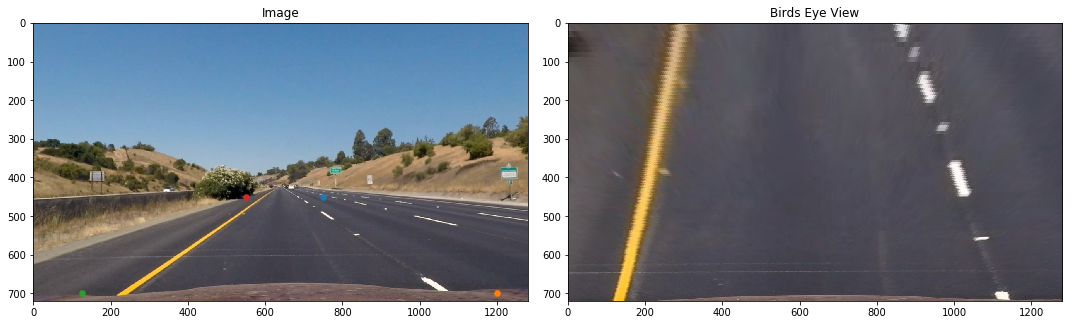

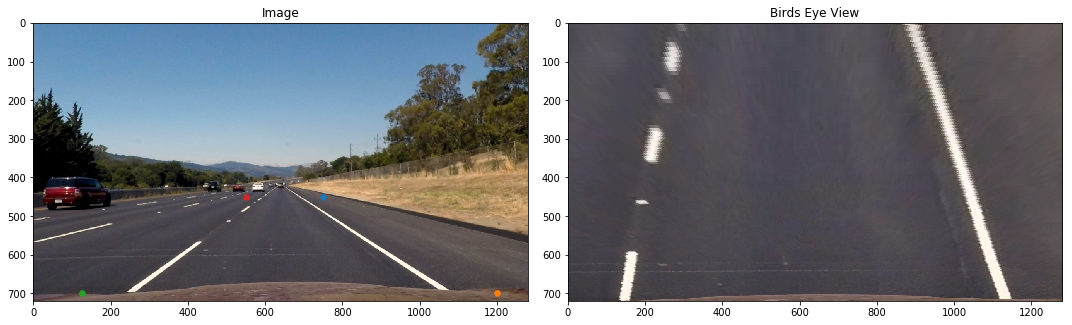

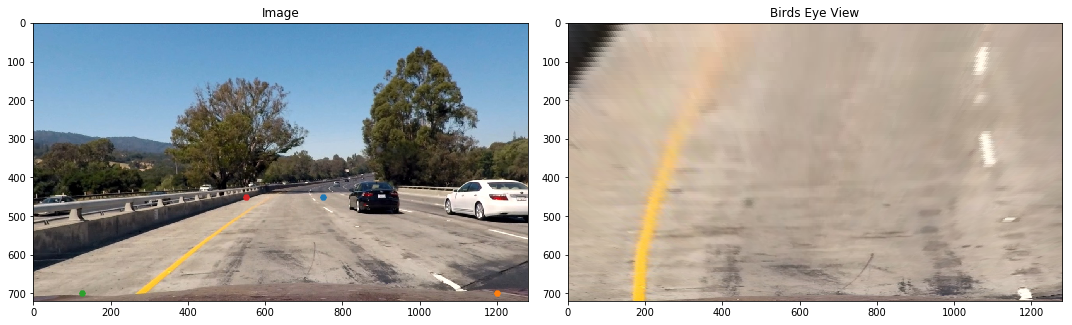

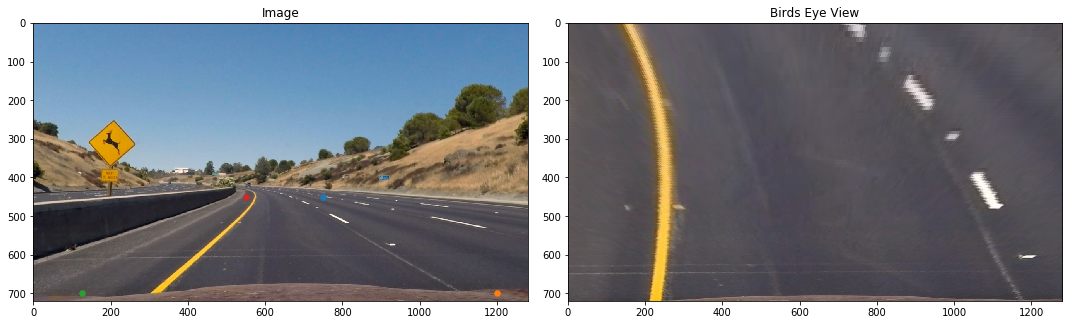

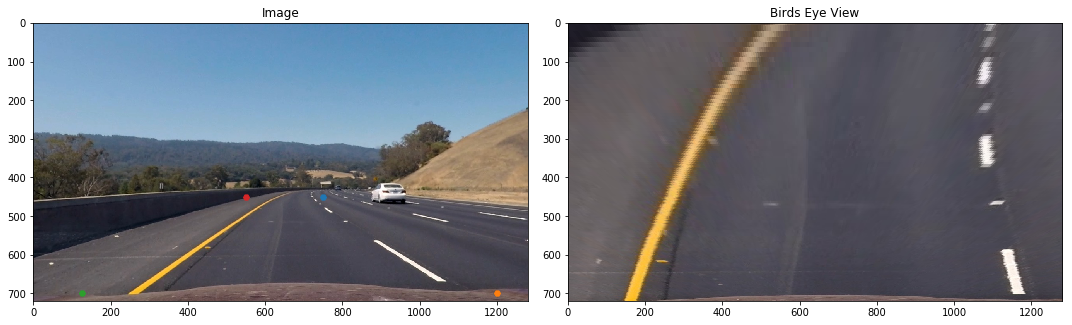

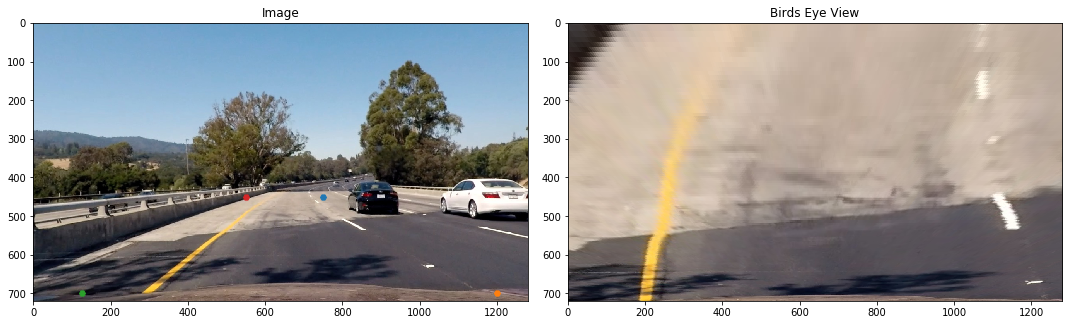

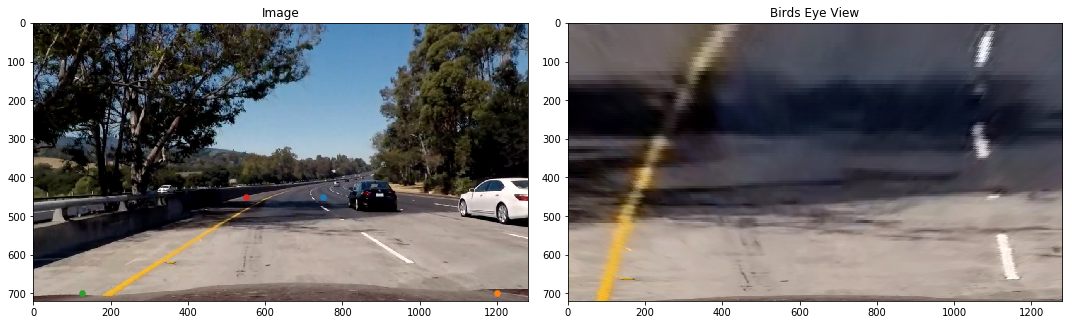

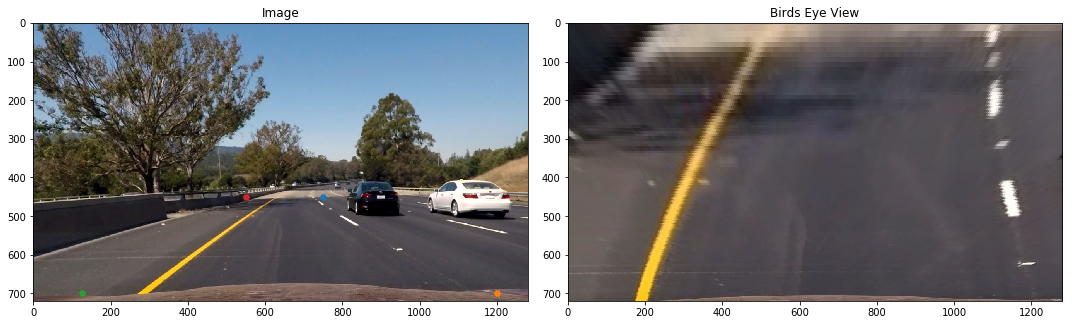

In [9]:
#Empty list to add transformed images to
persp_imgs = []
#Transform each image as well as get inverse transformation matrix
for img in calib_imgs:
    Minv,birds_view = perspective_transform(img)
    persp_imgs.append(birds_view)
    perspective_comparison(img,birds_view)

## The next step is to move onto masking the images to more easily find the lane lines

In [10]:
def color_mask_comparison(img):
    #color mask image
    y_mask,w_mask,c_mask = mask(img)
    plt.figure(figsize=(15, 10))
    gs1 = gs.GridSpec(nrows=2, ncols=3)
    ax1 = plt.subplot(gs1[0, 0])
    ax1.set_title('Original')
    plt.imshow(img)
    plt.axis('off')

    ax2 = plt.subplot(gs1[0, 1])
    ax2.set_title('Yellow Mask')
    plt.imshow(y_mask,cmap='gray')
    plt.axis('off')
    
    ax3 = plt.subplot(gs1[0, 2])
    ax3.set_title('White Mask')
    plt.imshow(w_mask,cmap='gray')
    plt.axis('off')
    
    ax4 = plt.subplot(gs1[1, :])
    ax4.set_title('Combined Masks')
    plt.imshow(c_mask,cmap='gray')
    plt.axis('off')

    plt.tight_layout()

    plt.show()

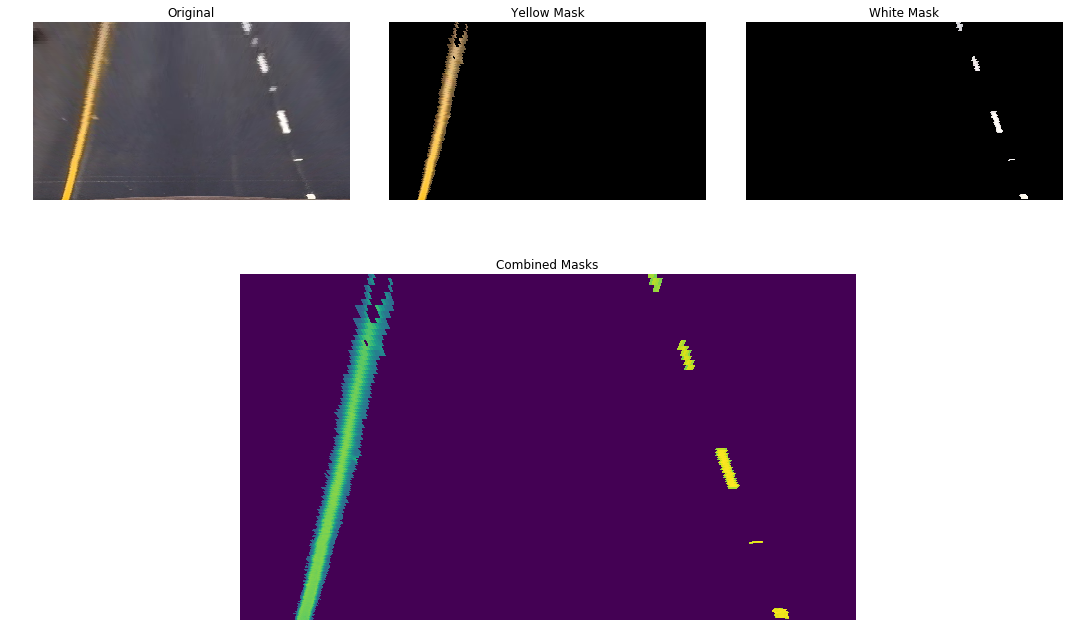

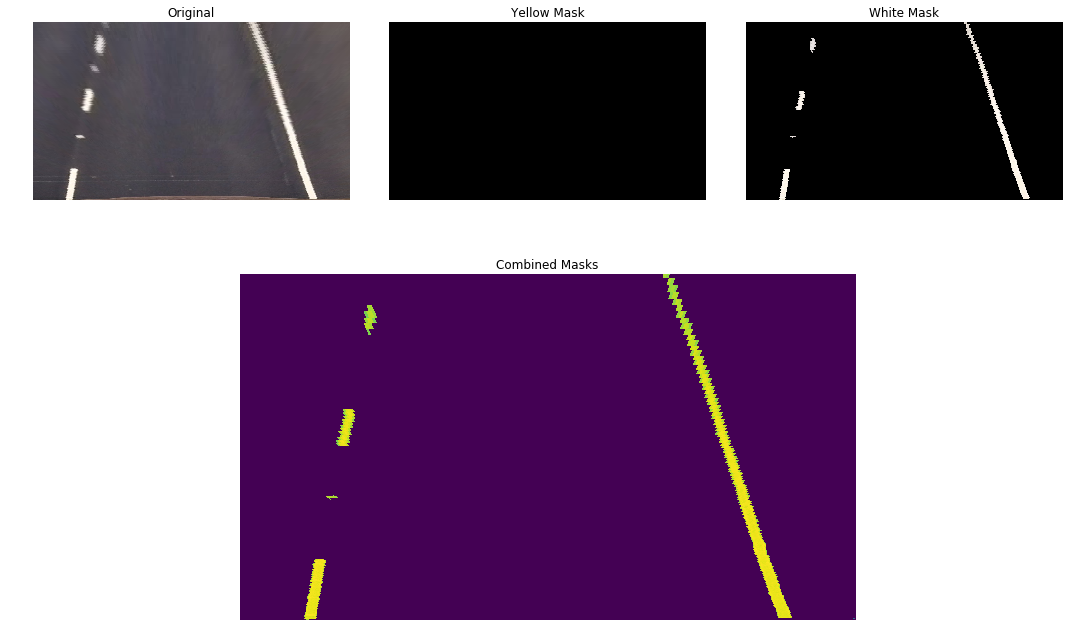

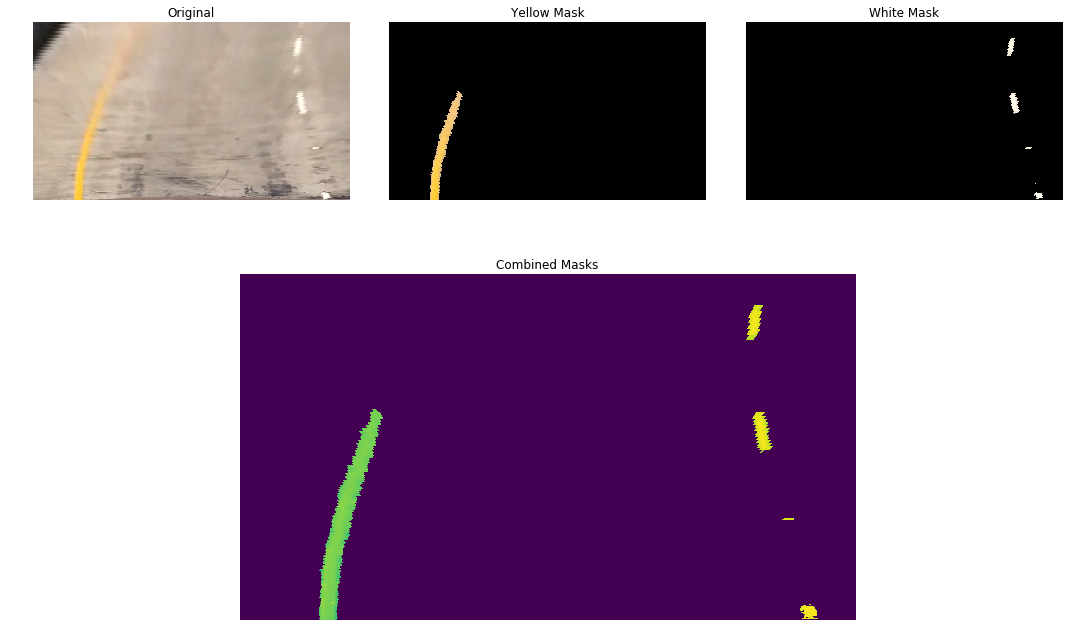

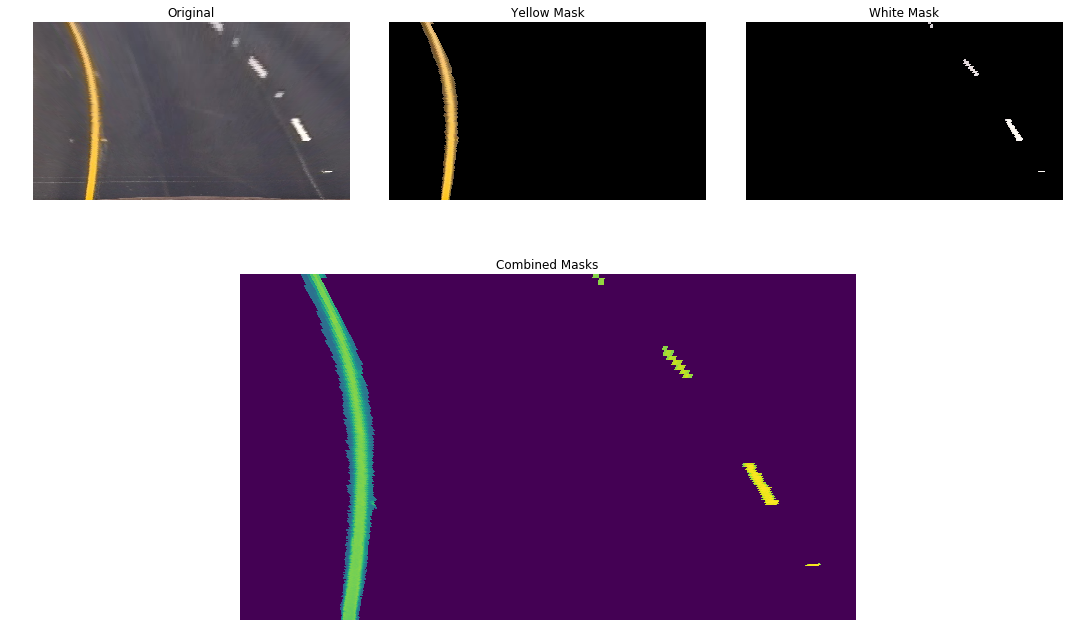

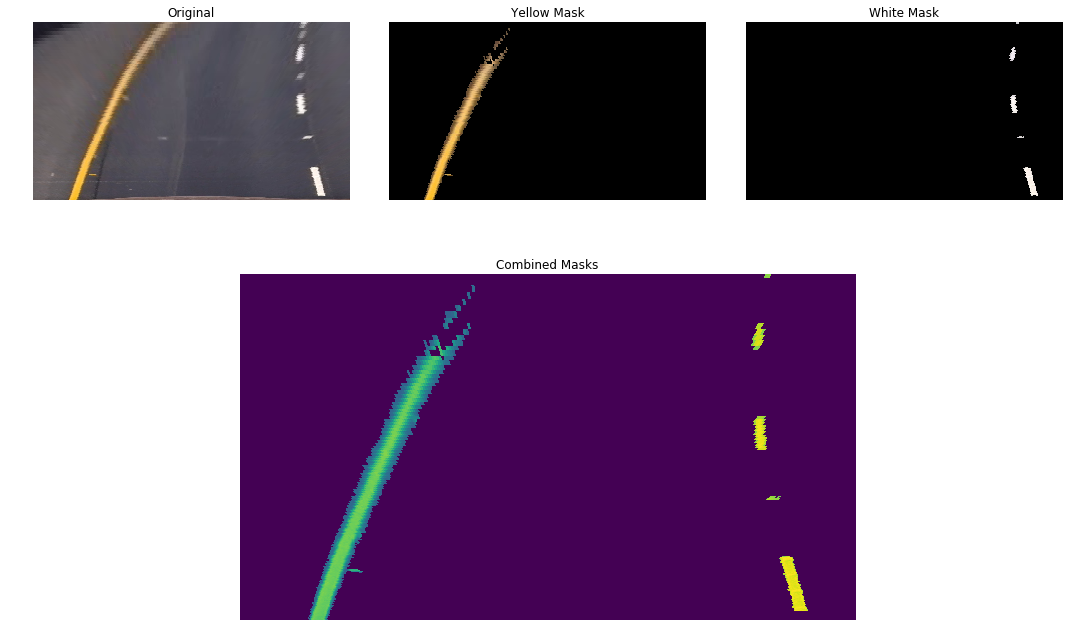

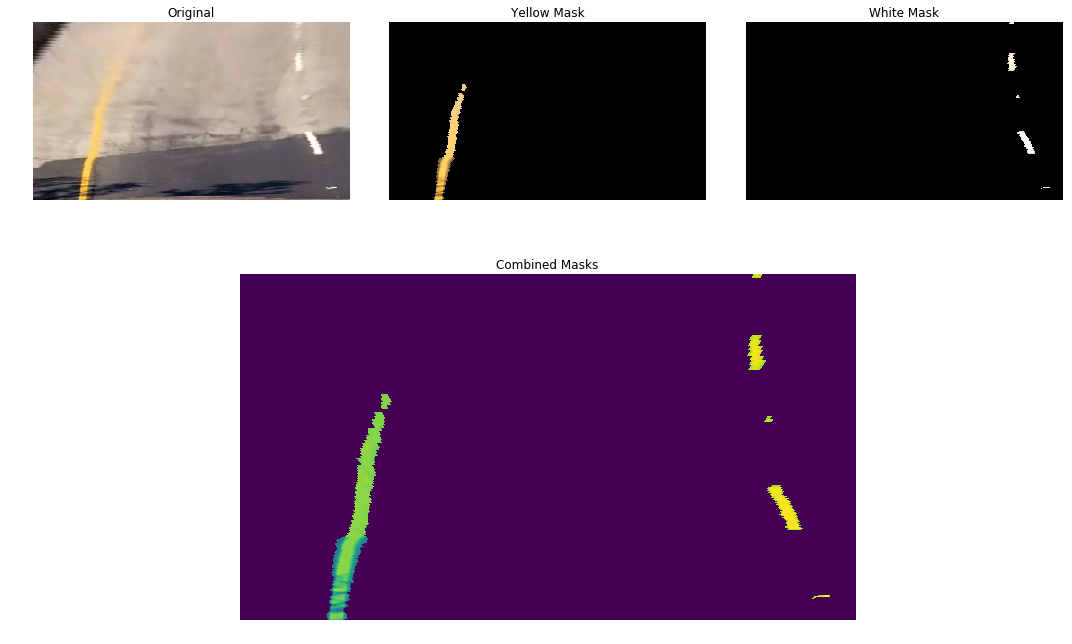

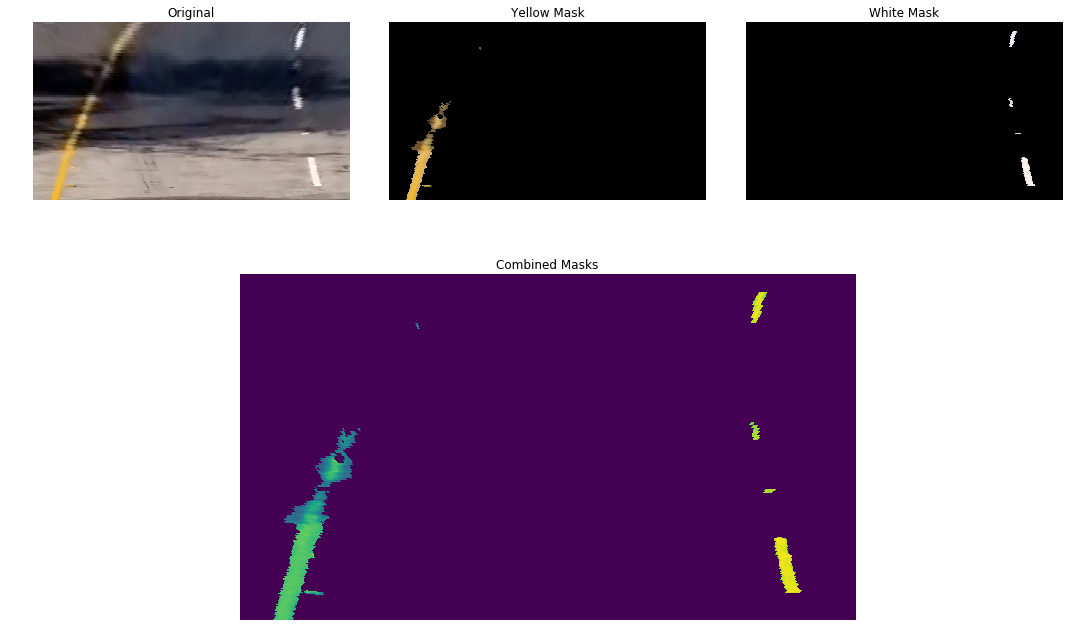

In [11]:
for img in persp_imgs:
    color_mask_comparison(img)

## The HLS color space is great at separating the lines using the sobel operator, here I plot each channel to see which ones work best

In [ ]:
def hls_comparison(hls_img):
    H = hls_img[:, :, 0]
    L = hls_img[:, :, 1]
    S = hls_img[:, :, 2]

    plt.figure(figsize=(15, 10))
    gs1 = gs.GridSpec(nrows=1, ncols=3)
    
    ax1 = plt.subplot(gs1[0, 0])
    ax1.set_title('Hue Channel')
    plt.imshow(H, cmap='gray')
    plt.axis('off')

    ax2 = plt.subplot(gs1[0, 1])
    ax2.set_title('Light Channel')
    plt.imshow(L, cmap='gray')
    plt.axis('off')

    ax3 = plt.subplot(gs1[0, 2])
    ax3.set_title('Saturation Channel')
    plt.imshow(S, cmap='gray')
    plt.axis('off')

In [4]:
persp_img = persp_imgs[4]
plt.imshow(persp_img)
plt.show()

hls = cv2.cvtColor(persp_img,cv2.COLOR_RGB2HLS)
hls_comparison(hls)

NameError: name 'persp_imgs' is not defined

## Next we apply the sobel operator on the L and S channel in the x direction. I found that this was the method that produced the best results with the least amount of noise

In [ ]:
h=hls[:,:,0]
l=hls[:,:,1]
s=hls[:,:,2]

#Previous sobel testing with different functions
#mag_mask = mag_thresh(hls[:, :, 1],mag_thresh=(20,150))
#sobely_mask = abs_sobel_thresh(l, orient='y', thresh=(50, 225))
#sobel_mag = mag_thresh(l, mag_thresh=(20, 265))
#sobel_dir = dir_threshold(l, thresh=(0.7, 1.3))

#Sobel in the L and S Channel in the X direction combined into one mask
sobelx_light_mask = abs_sobel_thresh(l, orient='x', thresh=(50, 225))
sobelx_saturation_mask = abs_sobel_thresh(s, orient='x', thresh=(50, 225))
combined_sobel = cv2.bitwise_or(sobelx_light_mask, sobelx_saturation_mask)

In [ ]:
def sobel_comparison(sobelx_light_mask, sobelx_saturation_mask, combined_sobel):
    plt.figure(figsize=(15, 10))
    gs1 = gs.GridSpec(nrows=1, ncols=3)
    
    ax1 = plt.subplot(gs1[0, 0])
    ax1.set_title('Sobel X Light')
    plt.imshow(sobelx_light_mask, cmap='gray')
    plt.axis('off')

    ax2 = plt.subplot(gs1[0, 1])
    ax2.set_title('Sobel X Saturation')
    plt.imshow(sobelx_saturation_mask, cmap='gray')
    plt.axis('off')

    ax3 = plt.subplot(gs1[0, 2])
    ax3.set_title('Combined Sobel')
    plt.imshow(combined_sobel, cmap='gray')
    plt.axis('off')

In [ ]:
sobel_comparison(sobelx_light_mask,sobelx_saturation_mask,combined_sobel)

## Once we have both the sobel masking as well as color masking we combine the two to get our final masked images

In [ ]:
final_masks =[]
for mask_img in persp_imgs:
    #Color masking
    y,w,color_mask = mask(mask_img)
    #Sobel Masking
    hls = cv2.cvtColor(mask_img,cv2.COLOR_RGB2HLS)
    h=hls[:,:,0]
    l=hls[:,:,1]
    s=hls[:,:,2]
    sobelx_light_mask = abs_sobel_thresh(l, orient='x', thresh=(50, 225))
    sobelx_saturation_mask = abs_sobel_thresh(s, orient='x', thresh=(50, 225))
    combined_sobel = cv2.bitwise_or(sobelx_light_mask, sobelx_saturation_mask)
    #Final Mask
    final_mask = cv2.bitwise_or(combined_sobel,color_mask)
    final_masks.append(final_mask)

In [ ]:
def show_all_masks(masks):
    plt.figure(figsize=(15, 10))
    gs1 = gs.GridSpec(nrows=3, ncols=3)
    
    for i in range(0,len(masks)):
        ax = plt.subplot(gs1[i])
        plt.imshow(masks[i],cmap='gray')
    plt.show()

In [ ]:
show_all_masks(final_masks)

## From here we move on to detecting which pixels are noise and which pixels are the lane line

In [ ]:
#Example Image
binary_warped=final_masks[0]
original_img = calib_imgs[0]
#Take Histogram of bottom half of image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)
plt.show()

In [5]:
out_img = np.dstack(
    (binary_warped, binary_warped, binary_warped)) * 255  # Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0] / 2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0] / nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window + 1) * window_height
    win_y_high = binary_warped.shape[0] - window * window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2)
    cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2)
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (
        nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (
        nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds]
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

NameError: name 'binary_warped' is not defined

In [ ]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [ ]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2 * left_fit[0] * y_eval + left_fit[1]) ** 2) ** 1.5) / np.absolute(2 * left_fit[0])
right_curverad = ((1 + (2 * right_fit[0] * y_eval + right_fit[1]) ** 2) ** 1.5) / np.absolute(2 * right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48

In [ ]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30 / 720  # meters per pixel in y dimension
xm_per_pix = 3.7 / 700  # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
right_fit_cr = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
    2 * left_fit_cr[0])
right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
    2 * right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

In [ ]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (original_img.shape[1], original_img.shape[0]))
# Combine the result with the original image
result = cv2.addWeighted(original_img, 1, newwarp, 0.3, 0)
plt.imshow(result)

## Full lane detection pipeline

In [ ]:
def sliding_window(binary_warped):
    out_img = np.dstack((binary_warped, binary_warped,
                         binary_warped)) * 255  # Find the peak of the left and right halves of the histogram
    histogram = np.sum(binary_warped[binary_warped.shape[0] // 2:, :], axis=0)
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0] / 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0] / nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2)
        cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (
            nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (
            nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]

    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2 * left_fit[0] * y_eval + left_fit[1]) ** 2) ** 1.5) / np.absolute(2 * left_fit[0])
    right_curverad = ((1 + (2 * right_fit[0] * y_eval + right_fit[1]) ** 2) ** 1.5) / np.absolute(2 * right_fit[0])

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30 / 720  # meters per pixel in y dimension
    xm_per_pix = 3.7 / 700  # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
        2 * left_fit_cr[0])
    right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
        2 * right_fit_cr[0])

    return left_fitx, right_fitx, ploty, left_curverad, right_curverad

In [ ]:
def draw_lane(image, binary_warped, Minv, left_fitx, right_fitx, ploty, left_curverad, right_curverad):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    cv2.putText(result, "Left Lane Radius: " + "{:0.2f}".format(left_curverad / 1000) + 'km', org=(50, 50),
                fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=1, color=(0, 0, 0), lineType=cv2.LINE_AA, thickness=2)
    cv2.putText(result, "Right Lane Radius: " + "{:0.2f}".format(right_curverad / 1000) + 'km', org=(50, 100),
                fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=1, color=(0, 0, 0), lineType=cv2.LINE_AA, thickness=2)
    return result

In [ ]:
def pipeline(image, video=True):
    if video == False:
        # Load Image
        image = mpimg.imread(image)

        # Undistort Image
        undist = undistort(image, objpoints, imgpoints)

        # Perspective Transform
        Minv, birds_view = perspective_transform(undist)

        # Masking
        binary_warped = final_mask(birds_view)

        # Find corresponding lane pixels
        left_fitx, right_fitx, ploty, left_curverad, right_curverad = sliding_window(binary_warped)

        # Draw lane lines onto image
        drawn_lines = draw_lane(image, binary_warped, Minv, left_fitx, right_fitx, ploty, left_curverad, right_curverad)
        return drawn_lines




    else:
        # Undistort Image
        undist = undistort(image, objpoints, imgpoints)

        # Perspective Transform
        Minv, birds_view = perspective_transform(undist)

        # Masking
        binary_warped = final_mask(birds_view)

        # Find corresponding lane pixels
        left_fitx, right_fitx, ploty, left_curverad, right_curverad = sliding_window(binary_warped)

        # Draw lane lines onto image
        drawn_lines = draw_lane(image, binary_warped, Minv, left_fitx, right_fitx, ploty, left_curverad, right_curverad)
        return drawn_lines

In [ ]:
def show_test_imgs(images):
    plt.figure(figsize=(15, 10))
    gs1 = gs.GridSpec(nrows=3, ncols=3)

    for i in range(0, len(images)):
        ax = plt.subplot(gs1[i])
        plt.imshow(images[i])
    plt.show()

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
mod_imgs = []
for img in all_imgs:
    mod_imgs.append(pipeline(img,video=False))
# project_video = 'video_output/project_video_output.mp4'
# clip1 = VideoFileClip('project_videoTrim.mp4')
# project_clip = clip1.fl_image(main_pipeline) #NOTE: this function expects color images!!
# %time project_clip.write_videofile(project_video, audio=False)